# Ejemplo de Segmentación

En esta sección de la práctica vamos a emplear una CNN para segmentación de instancias. La CNN más conocida es MaskRCNN. Existen modelos preentrenados sobre la base de datos [COCO](https://cocodataset.org/#home) formada por +220k imágenes etiquetadas en 80 categorias.

Esta vez, vamos a ver como podemos emplear un repositorio público para segmentar una imagen propia. Lo primero que hacemos es descargarnos el proyecto del repositorio de Github.

Concretamente: Mask-RCNN-Shiny

In [ ]:
! git clone https://github.com/huuuuusy/Mask-RCNN-Shiny.git

**Una vez clonado el repositorio, copiamos la carpeta "mrcnn" y "samples" al directorio en el que vamos a trabajar.**

Tenemos que instalar una versión anterior de tensorflow y keras ya que MaskRCNN fue construído con tensorflow 1.x y todavía no se ha adaptado a tensorflow 2.x.

Aquí tenemos un [enlace](https://blog.paperspace.com/mask-r-cnn-tensorflow-2-0-keras/) donde se explica como podríamos hacer correr MaskRCNN con tensorflow 2.x.

NOTA: Cuando hagamos la instalación puede ser que salga un botón para reiniciar el interepreter. En caso de que salga deberemos de pulsar sobre él.

In [ ]:
! pip install keras==2.2.4
! pip install tensorflow==1.14.0
! pip install h5py==2.10.0

In [ ]:
import tensorflow as tf
import keras

print('Versión tensorflow: ', tf.__version__)
print('Versión keras: ', keras.__version__)

In [ ]:
import cv2
import numpy as np
import os
import sys
from samples import coco
from mrcnn import utils
from mrcnn import model as modellib

In [ ]:
# Input the original image name
original_image = 'images/ciclista.jpeg'

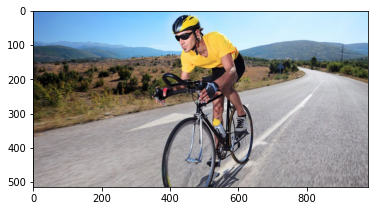

In [ ]:
import matplotlib.pyplot as plt
# Use OpenCV to read and show the original image
image = cv2.imread(original_image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

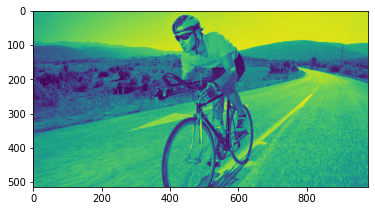

In [ ]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)
plt.show()

Vamos a descargar los pesos que se obtuvieron al entrenar MaskRCNN con la base de datos de COCO.

In [ ]:
import urllib.request
import shutil

COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"

with urllib.request.urlopen(COCO_MODEL_URL) as resp, open('./mask_rcnn_coco.h5', 'wb') as out:
        shutil.copyfileobj(resp, out)

In [ ]:
# Load the pre-trained model data
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
# Change the config information
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    
    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()

In [ ]:


# COCO dataset object names
model = modellib.MaskRCNN(
    mode="inference", model_dir=MODEL_DIR, config=config
)
model.load_weights(COCO_MODEL_PATH, by_name=True)
class_names = [
    'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
# This function is used to change the colorful background information to grayscale.
# image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
# mask == 0 means that this pixel is not belong to the object.
# np.where function means that if the pixel belong to background, change it to gray_image.
# Since the gray_image is 2D, for each pixel in background, we should set 3 channels to the same value to keep the grayscale.

def apply_mask(image, mask):
    image[:, :, 0] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 2]
    )
    return image

In [ ]:
# This function is used to show the object detection result in original image.
def display_instances(image, boxes, masks, ids, names, scores):
    # max_area will save the largest object for all the detection results
    max_area = 0
    
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue

        # apply mask for the image
    # by mistake you put apply_mask inside for loop or you can write continue in if also
    image = apply_mask(image, mask)
        
    return image

Para cada imagen tenemos:

- rois: Las cajas alrededor de cada objeto detectado.
- masks: Las máscaras de cada objeto.
- class_ids: El ID de las clases de los objetos detectados.
- scores: La probabilidad de la clase identificada para cada objeto.


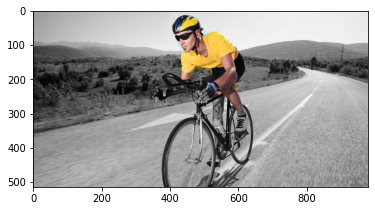

In [ ]:
results = model.detect([image], verbose=0)
r = results[0]
frame = display_instances(
    image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
)

plt.imshow(frame)
plt.show()


In [ ]:
cv2.imwrite("./images/only_ciclist.jpg", frame)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite("./images/only_ciclist2.jpg", frame)

True